<a href="https://colab.research.google.com/github/carlotta-marchis/kaggle-digit-recognition/blob/master/kaggle_digit_classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Classify handwritten digits
---

For this small project I will use the famous MNIST handwritten digit database. The aim is to train a machine learning model to be able to identify correctly the digits in the *train dataset* and make predictions for the digits in the *test dataset*.

In [0]:
# TensorFlow and tf.keras
import tensorflow as tf
from tensorflow import keras

# Helper libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns; sns.set()

print(tf.__version__)

2.2.0-rc1


## Importing the dataset from Kaggle

Here I import the MNIST dataset from [Kaggle](https://www.kaggle.com/c/digit-recognizer/data), using the Kaggle API.

Firsly, I install `kaggle`.

In [0]:
!pip3 install kaggle --upgrade

Requirement already up-to-date: kaggle in /usr/local/lib/python3.6/dist-packages (1.5.6)


Then I download the data directly to the content using the Kaggle API.

In [0]:
import os
os.environ['KAGGLE_USERNAME'] = "carlotta90" # username from the json file
os.environ['KAGGLE_KEY'] = "dfd6aaf2c8fc489f6c9103dca97120b2" # key from the json file
!kaggle competitions download -c digit-recognizer # api copied from kaggle

sample_submission.csv: Skipping, found more recently modified local copy (use --force to force download)
test.csv.zip: Skipping, found more recently modified local copy (use --force to force download)
train.csv.zip: Skipping, found more recently modified local copy (use --force to force download)


In [0]:
!unzip \*.zip

Archive:  test.csv.zip
replace test.csv? [y]es, [n]o, [A]ll, [N]one, [r]ename: y
  inflating: test.csv                

Archive:  train.csv.zip
replace train.csv? [y]es, [n]o, [A]ll, [N]one, [r]ename: y
  inflating: train.csv               

2 archives were successfully processed.


In [0]:
!ls -a

.	 model.h5	    sample_submission.csv  train.csv
..	 my_submission.csv  test.csv		   train.csv.zip
.config  sample_data	    test.csv.zip


The files `sample_submission.csv`, `test.csv` and `train.csv` are now in my content and ready to be imported and used.

In [0]:
train = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')
sample = pd.read_csv('sample_submission.csv')

## Exploring the data

The following shows that the `train.csv` file contains 42,000 images each of which is represented by 784 pixels (28x28). Moreover, each image has an associated `label` denoting the handwritten digit, which ranges from 0 to 9. 

In [0]:
train.shape

(42000, 785)

In [0]:
train.columns

Index(['label', 'pixel0', 'pixel1', 'pixel2', 'pixel3', 'pixel4', 'pixel5',
       'pixel6', 'pixel7', 'pixel8',
       ...
       'pixel774', 'pixel775', 'pixel776', 'pixel777', 'pixel778', 'pixel779',
       'pixel780', 'pixel781', 'pixel782', 'pixel783'],
      dtype='object', length=785)

In [0]:
train.label.describe()

count    42000.000000
mean         4.456643
std          2.887730
min          0.000000
25%          2.000000
50%          4.000000
75%          7.000000
max          9.000000
Name: label, dtype: float64

Likewise, what follows shows that the `test.csv` file contains 28,000 images each of which is represented by 784 pixels (28x28). In this case no label is given, as the pourpouse of the Kaggle competition is to predict the labels for the test datasubset.

In [0]:
test.shape

(28000, 784)

In [0]:
test.columns

Index(['pixel0', 'pixel1', 'pixel2', 'pixel3', 'pixel4', 'pixel5', 'pixel6',
       'pixel7', 'pixel8', 'pixel9',
       ...
       'pixel774', 'pixel775', 'pixel776', 'pixel777', 'pixel778', 'pixel779',
       'pixel780', 'pixel781', 'pixel782', 'pixel783'],
      dtype='object', length=784)

## Features matrix and target array 

I now define the features matrix and target array, and then split them into a **training set** and a **test set** in order to be able to evaluate the accuracy of the trained model before making predections.

In [0]:
X = np.array(train.drop('label', axis=1))
y = np.array(train['label'])

from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y)

The following figure shows the first 25 images of the training set:

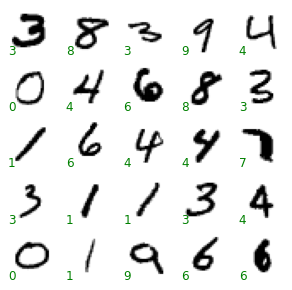

In [0]:
# Define images by reshaping the one-dimensional arrays (784 pixels) into a 
# two-dimensional arrays (28x28 pixels) 
train_images = np.reshape(X_train, (len(X_train),28,28))
test_images = np.reshape(X_test, (len(X_test),28,28))

# Plot the first 25 train images
plt.figure(figsize=(5,5))
for i in range(25):
  plt.subplot(5, 5, i+1)
  plt.imshow(train_images[i], cmap='binary')
  plt.text(0,28, y_train[i], color='green')
  plt.xticks([])
  plt.yticks([])
plt.show()

Finally, to avoid confusion of notation I rename the dataset that will be used to make prediction as `to_predict`.

In [0]:
to_predict = np.array(test)
images_to_predict = np.reshape(to_predict, (len(to_predict),28,28))

## Preprocessing the data 

To be able to feed the `X_train`, `X_test` and `to_predict` arrays to a neural network model they need to be preprocessed, in fact: 

In [0]:
print('Each image pixel has a value between 0 and ' + str(X_train.max()) + ' inclusive:')

Each image pixel has a value between 0 and 255 inclusive:


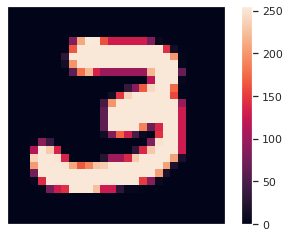

In [0]:
plt.figure()
plt.imshow(train_images[0])
plt.xticks([])
plt.yticks([])
plt.colorbar()
plt.show()

It is therefore necessary to rescale them to a range of 0 and 1:

In [0]:
X_train = X_train / 255.0
X_test = X_test / 255.0
to_predict = to_predict / 255.0

## Builing the model

Building the model requires:
- **configuring** the layers of the model, 
- **compiling** the model

### Configuring the layers

I will start by configuring a tiny model with 2 intermediate, fully connected layers of 16 nodes, and a final layer of 10 nodes, one for each class:

In [0]:
tiny_model = keras.Sequential([
        keras.layers.Dense(16, activation='relu', input_shape=(784,)),
        keras.layers.Dense(16, activation='relu'),
        keras.layers.Dense(10, activation='softmax')
                          ])

The first layer in this network, `tf.keras.layers.Dense(16, input_shape=(784,), activation='relu')` takes as input arrays of shape (, 784) (the 0th layer) and output arrays of shape (, 16) (the 1st layer).

Then the network consists of two additional **fully connected** neural layers. The first one has 16 nodes (or neurons). The second one is an array of lenght 10. The Softmax function squashes the vector in the range (0, 1), such that the sum of the resulting elements is 1. As each element represents a class, they can be interpreted as class probabilities.

### Compiling the model

Before training the model we need to compile it by setting three key parameters:
- The **optimizer**. I will use the default Adam gradient-based optimizer. 
- The **loss function**. I will use [`SparseCategoricalCrossentropy`](https://www.tensorflow.org/api_docs/python/tf/keras/losses/SparseCategoricalCrossentropy) as the data have more than two integer valued label classes (0 to 9). (*Note: Keras distinguishes between `binary_crossentropy` for 2 classes and `categorical_crossentropy` for more than 2 classes*).
- A list of **metrics**. Since this is a classification problem, we’ll just have Keras report on the accuracy metric.

In [0]:
tiny_model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(),
              metrics=['accuracy'])

## Training the model

Training the model consists in calling the `model.fit` function and specifying some parameters as:

- The **training data**, which are the images and labels stored in the `X_train` and `y_train` arrays respectively.
- The **number of epochs** (iterations over the entire dataset) to train for.
- The **batch size** (number of samples per gradient update) to use when training.

Here is a useful [link](https://machinelearningmastery.com/difference-between-a-batch-and-an-epoch/) to better understand the meaning of batch size and epochs.

In [0]:
tiny_model.fit(X_train, y_train, epochs=5, batch_size=32)

Epoch 1/5
985/985 [==============================] - 2s 2ms/step - loss: 0.6365 - accuracy: 0.8166
Epoch 2/5
985/985 [==============================] - 2s 2ms/step - loss: 0.2894 - accuracy: 0.9168
Epoch 3/5
985/985 [==============================] - 2s 2ms/step - loss: 0.2455 - accuracy: 0.9288
Epoch 4/5
985/985 [==============================] - 2s 2ms/step - loss: 0.2211 - accuracy: 0.9355
Epoch 5/5
985/985 [==============================] - 2s 2ms/step - loss: 0.2020 - accuracy: 0.9409


As the model trains, the loss and accuracy metrics are displayed. This model reaches an accuracy of about 0.94 (or 94%) on the training data.

### Evaluating accuracy

In [0]:
test_loss, test_acc = tiny_model.evaluate(X_test,  y_test, verbose=2)

print('\nTest accuracy:', test_acc)

329/329 - 0s - loss: 0.2284 - accuracy: 0.9332

Test accuracy: 0.9332380890846252


It turns out that the accuracy on the test dataset is a little less than the accuracy on the training dataset. This gap between training accuracy and test accuracy represents **overfitting**. One of the most common way to reduce overfitting is to add **Dropout** layers in the network ([source](https://www.tensorflow.org/tutorials/keras/overfit_and_underfit#demonstrate_overfitting)).

## Making predictions

The model can now be used to make predictions by calling the `predict` method:

In [0]:
predictions = tiny_model.predict(X_test)

In [0]:
predictions.shape

(10500, 10)

`predictions` consists of 10,050 arrays of 10 numbers, representing the probabilities for each of the 10,500 sample of belonging to one of the 10 classes (the digits between 0 and 9).

In [0]:
predictions[0]

array([2.6539570e-07, 1.4940365e-08, 9.9985516e-01, 1.4306535e-04,
       2.0128600e-11, 1.4523421e-06, 3.0513516e-09, 3.5947348e-08,
       3.0523314e-08, 1.9438132e-12], dtype=float32)

### Verifying predictions

Before trying to improve the performance of the model by changing the neural network structure, it can be interesting to check where and when this initial tiny model fails.

These two functions will help us visualize the result of the prediction.

In [0]:
def plot_image(i, prediction_arrays, true_labels, imgages):
  predicted_label, true_label, imgage = np.argmax(prediction_arrays[i]), true_labels[i], imgages[i]
  
  plt.grid(False)
  plt.imshow(imgage, cmap='binary')
  plt.xticks([])
  plt.yticks([])

  plt.text(0,28, predicted_label, color='blue' if predicted_label == true_label else 'red')
  

def plot_labels(i, prediction_arrays, true_labels):
  predicted_label, true_label = np.argmax(prediction_arrays[i]), true_labels[i]
  
  plt.grid(False)
  thisplot = plt.bar(range(10), prediction_arrays[i], color="#777777")
  plt.xticks(range(0,10))
  plt.yticks([])
  plt.ylim([0, 1])
  
  thisplot[predicted_label].set_color('red')
  thisplot[true_label].set_color('blue')

Now, let's look at the 0th image. Correct prediction labels are blue and incorrect prediction labels are red.

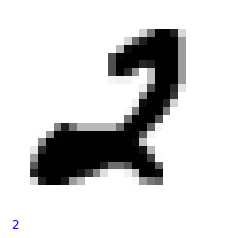

In [0]:
plot_image(0, predictions, y_test, test_images)

The figure shows that tiny model correctly predicted the class of the first image.

Let's look at the first 15 predictions:

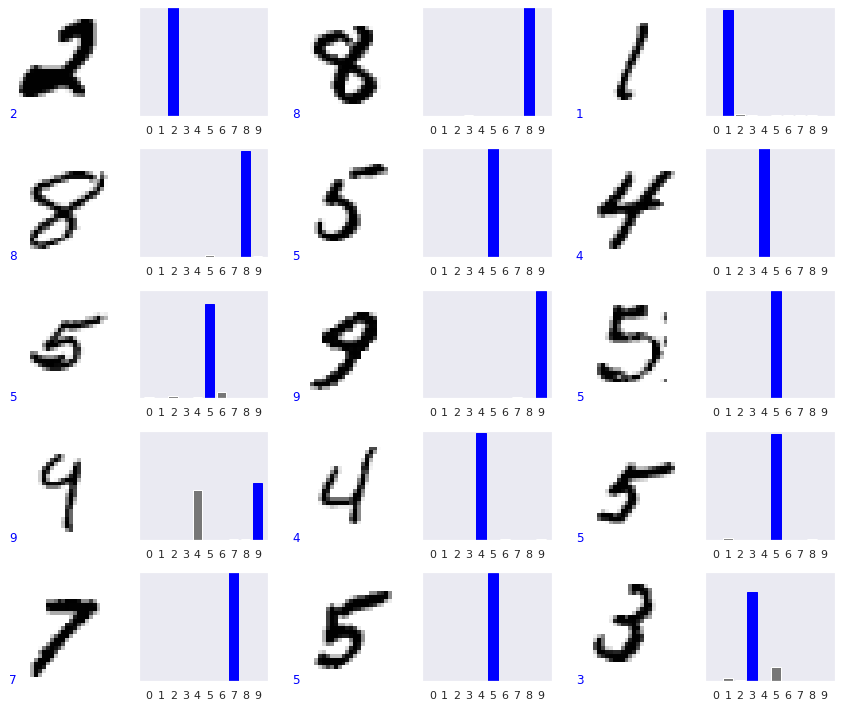

In [0]:
# Plot the first n_row*n_cols test images and the labels probabilities
n_rows = 5
n_cols = 3
n_images = n_rows*n_cols

plt.figure(figsize=(2*2*n_cols,2*n_rows))
for i in range(n_images):
  plt.subplot(n_rows, 2*n_cols, 2*i+1)
  plot_image(i, predictions, y_test, test_images)
  plt.subplot(n_rows, 2*n_cols, 2*i+2)
  plot_labels(i, predictions, y_test)
plt.tight_layout()
plt.show()

The model correctly identifies all the 15 images.

Finally, let's look at the first 15 images the model incorrectly predicts:

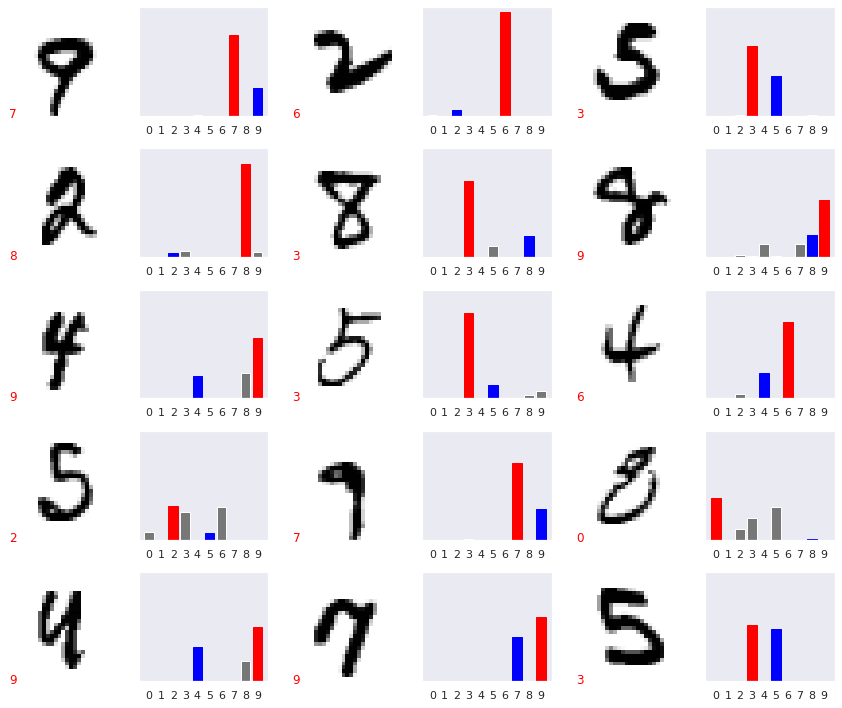

In [0]:
predicted_labels = []

for i in range(len(predictions)):
  predicted_labels.append(np.argmax(predictions[i]))

select_incorrect = ~(predicted_labels == y_test)

incorrect_predictions = predictions[select_incorrect]
incorrect_images = test_images[select_incorrect]
incorrect_labels = y_test[select_incorrect]

# Plot the first n_row*n_cols test images and the labels probabilities
n_rows = 5
n_cols = 3
n_images = n_rows*n_cols

plt.figure(figsize=(2*2*n_cols,2*n_rows))
for i in range(n_images):
  plt.subplot(n_rows, 2*n_cols, 2*i+1)
  plot_image(i, incorrect_predictions, incorrect_labels, incorrect_images)
  plt.subplot(n_rows, 2*n_cols, 2*i+2)
  plot_labels(i, incorrect_predictions, incorrect_labels)
plt.tight_layout()
plt.show()

From this figure it is possible to see that more often then not, when the model makes an incorrect prediction, the higher probability is not as close to one as for when the model correctly predicts the label of the handwritten digit (compare with the previous figure). It will be interesting to see how and if this changes when changin the model structure.

## Changing the neural network structure

I will now configure compile and train a network with a different structure. More specifically I will make the following changes:

- increase the **network depth** by adding a new layer
- change the **number of nodes** in the hidden layers 
- add **Dropout** layers
- change the **batch size** and **number of epochs**
- use the testing subset for **validation** during training  
  *(Note: Keras will evaluate the model on the validation set at the end of each epoch and report the loss and any metrics. This allows one to monitor the model’s progress over time during training, useful to identify overfitting and support early stopping.)*


In [0]:
# Building the model
model = keras.Sequential([
        keras.layers.Dense(392, activation='relu', input_shape=(784,)),
        keras.layers.Dropout(0.5),
        keras.layers.Dense(196, activation='relu'),
        keras.layers.Dropout(0.5),
        keras.layers.Dense(98, activation='relu'),
        keras.layers.Dropout(0.5),
        keras.layers.Dense(10, activation='softmax')
                          ])

# Compiling the model
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(),
              metrics=['accuracy'])

# Training the model
model.fit(X_train, y_train, epochs=10, batch_size=64, 
          validation_data=(X_test, y_test))

Epoch 1/10
493/493 [==============================] - 1s 3ms/step - loss: 0.7533 - accuracy: 0.7579 - val_loss: 0.2172 - val_accuracy: 0.9378
Epoch 2/10
493/493 [==============================] - 1s 3ms/step - loss: 0.3179 - accuracy: 0.9125 - val_loss: 0.1697 - val_accuracy: 0.9524
Epoch 3/10
493/493 [==============================] - 1s 3ms/step - loss: 0.2470 - accuracy: 0.9335 - val_loss: 0.1480 - val_accuracy: 0.9568
Epoch 4/10
493/493 [==============================] - 1s 3ms/step - loss: 0.2055 - accuracy: 0.9433 - val_loss: 0.1364 - val_accuracy: 0.9615
Epoch 5/10
493/493 [==============================] - 1s 3ms/step - loss: 0.1839 - accuracy: 0.9495 - val_loss: 0.1233 - val_accuracy: 0.9660
Epoch 6/10
493/493 [==============================] - 1s 3ms/step - loss: 0.1637 - accuracy: 0.9555 - val_loss: 0.1201 - val_accuracy: 0.9681
Epoch 7/10
493/493 [==============================] - 1s 3ms/step - loss: 0.1471 - accuracy: 0.9591 - val_loss: 0.1108 - val_accuracy: 0.9680
Epoch 

This model reaches an accuracy of about 0.96 (or 96%) on the training data and of 0.97 on the test datasubset. Overfitting was successfully avoided.

## Using the model

In order to be able to load the model back up anytime I will save it to disk

In [0]:
model.save_weights('model.h5')

It is then possible to reload the trained model by rebuilding it and loading in the saved weights:

In [0]:
# Building the model
model = keras.Sequential([
        keras.layers.Dense(392, activation='relu', input_shape=(784,)),
        keras.layers.Dropout(0.5),
        keras.layers.Dense(196, activation='relu'),
        keras.layers.Dropout(0.5),
        keras.layers.Dense(98, activation='relu'),
        keras.layers.Dropout(0.5),
        keras.layers.Dense(10, activation='softmax')
                          ])

# Load the model's saved weights
model.load_weights('model.h5')

Now, the trained model can be used to make predictions by passing the `to_predict` array of inputs to `predict()`. This will return an array of outputs of 10 probabilities for each of the 28,000 images the model predicted, as shown below.


In [0]:
my_labels_prob = model.predict(to_predict)

In [0]:
my_labels_prob.shape

(28000, 10)

In [0]:
my_labels_prob[0]

array([2.25755097e-13, 2.87838026e-12, 1.00000000e+00, 1.09610845e-08,
       1.75131611e-15, 6.12302965e-16, 4.98670895e-17, 2.69131917e-09,
       4.61150649e-12, 2.47948030e-18], dtype=float32)

## Submitting the predictions

The last step consists in creating a csv file with the right format for the submission to the Kaggle competition.

Let's look at the `sample_submission.csv` file provided by Kaggle:

In [0]:
sample.head()

,ImageId,Label
0,1,0
1,2,0
2,3,0
3,4,0
4,5,0


In [0]:
len(sample)

28000

Hence, the sample submission consists in a DataFrame with two columns called `ImageId` and `Label`.
- The `ImageId` is the index incremented by 1.
- The `Label` is the predicted label for each image that can be calculated using the `np.argmax`

In [0]:
my_labels = []
for i in range(len(my_labels_prob)):
  my_labels.append(np.argmax(my_labels_prob[i]))

In [0]:
my_submission = pd.concat([pd.DataFrame([i+1 for i in range(28000)], columns=['ImageId']), 
                           pd.DataFrame(my_labels, columns=['Label'])], axis=1)

In [0]:
my_submission.head()

,ImageId,Label
0,1,2
1,2,0
2,3,9
3,4,9
4,5,3


Now that the predictions were put in the right format for submission, I can save the csv file and upload it using the Kaggle API:

In [0]:
my_submission.to_csv('my_submission.csv', index=False)

In [0]:
!kaggle competitions submit -c digit-recognizer -f my_submission.csv -m "These are my predictions"

100% 208k/208k [00:09<00:00, 21.3kB/s]
Successfully submitted to Digit Recognizer